<a href="https://colab.research.google.com/github/Katrin-Leberfinger/Hybrid-gender-debiased-music-recommendation/blob/main/AI_MasterThesis_Recommendations_LFM2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT for text embedding

Code Source:
https://gist.github.com/shubhamagarwal92/37ccb747f7130a35a8e76aa66d60e014

Interesting articles
https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#31-running-bert-on-our-text
https://www.kaggle.com/hassanamin/bert-pytorch-cola-classification


In [329]:
!pip install transformers

In [330]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from transformers import BertConfig, BertPreTrainedModel, BertModel, BertForSequenceClassification
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW
from torch import nn
from transformers import BertModel
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Read Data

In [331]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LFM2bDataset(Dataset):
    def __init__(self, data_all,tokenizer,max_length, text_col, item2pos, user2id):
        super(LFM2bDataset, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.item2pos = item2pos
        self.user2id = user2id
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index][self.text_col]
        user_id = self.user2id[ self.data_all.iloc[index]['user_id']]
        track_id = self.item2pos[ self.data_all.iloc[index]['track_id']]
        
        inputs = tokenizer.encode_plus(
            text1, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'user_id': torch.tensor(user_id, dtype=torch.long),
             'track_id': torch.tensor(track_id, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['count'], dtype=torch.float)
            }


In [332]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LFM2bDatasetMulitpleText(Dataset):
    def __init__(self, data_all,tokenizer,max_length, item2pos, user2id):
        super(LFM2bDataset, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.item2pos = item2pos
        self.user2id = user2id
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index]['lyrics_cleaned']
        text2 = self.data_all.iloc[index]['tags']
        text3 = self.data_all.iloc[index]['abstract']
        user_id = self.user2id[ self.data_all.iloc[index]['user_id']]
        track_id = self.item2pos[ self.data_all.iloc[index]['track_id']]
        
        inputs1 = tokenizer.encode_plus(
            text1, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        ids1 = inputs1["input_ids"]
        mask1 = inputs1["attention_mask"]

        inputs2 = tokenizer.encode_plus(
            text2, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        ids2 = inputs2["input_ids"]
        mask2 = inputs2["attention_mask"]

        inputs3 = tokenizer.encode_plus(
            text3, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        ids3 = inputs1["input_ids"]
        mask3 = inputs1["attention_mask"]

        return {
            'input_ids_lyrics': torch.tensor(ids1, dtype=torch.long),
            'attention_mask_lyrics': torch.tensor(mask1, dtype=torch.long),
            'input_ids_tags': torch.tensor(ids2, dtype=torch.long),
            'attention_mask_tags': torch.tensor(mask2, dtype=torch.long),
            'input_ids_abstract': torch.tensor(ids3, dtype=torch.long),
            'attention_mask_abstract': torch.tensor(mask3, dtype=torch.long),
            'user_id': torch.tensor(user_id, dtype=torch.long),
             'track_id': torch.tensor(track_id, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['count'], dtype=torch.float)
            }


In [333]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [334]:
%cd /content/drive/MyDrive/Master\ Thesis/data

/content/drive/MyDrive/Master Thesis/data


## Read Data: Lyrics 

In [335]:
data_tracks_lyrics = pd.read_csv("music/data_tracks_lyrics.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_tracks_tags_lyrics = pd.read_csv("music/data_tracks_tags_lyrics.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna().drop_duplicates('track_id')
data_bio = pd.read_csv("music/data_artists_biography.txt", sep=",").drop(['Unnamed: 0'],axis=1).dropna()
data_interaction = pd.read_csv("music/data_user_track_interaction_old.txt", sep="\t").drop(['Unnamed: 0'],axis=1)

data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_bio)
data_interaction = data_interaction.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates(), on = 'track_id', how = 'inner').drop_duplicates()
data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_interaction[['track_id']], on = 'track_id', how = 'inner').drop_duplicates()

data_user = pd.read_csv("music/data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)

In [336]:
data_interaction_one = data_interaction[data_interaction['count'] == 1]
data_interaction_one = data_interaction_one.merge(data_tracks_tags_lyrics[['track_id', 'lyrics_cleaned', 'tags', 'abstract']]).drop_duplicates()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


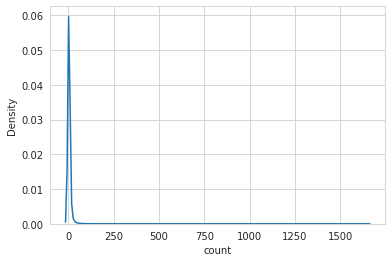

In [337]:
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(data_interaction['count'], bw=0.5)

In [338]:
# filter out playcount 1
data_interaction = data_interaction[data_interaction['count'] != 1]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


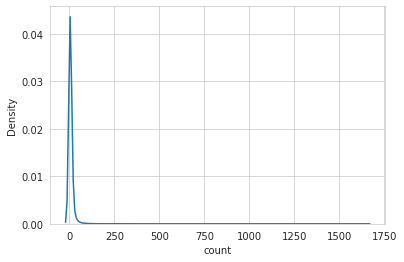

In [339]:
sns.kdeplot(data_interaction['count'], bw=0.5)

In [340]:
import random

selected_user = random.sample(list(data_interaction.user_id.unique()), 10000)
data_interaction = data_interaction.loc[(data_interaction.user_id.isin(selected_user))]

In [341]:
data_interaction.loc[data_interaction['count']<2., 'count'] = 0.
data_interaction.loc[data_interaction['count']>=2., 'count'] = 1.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


## CV and balance data set

In [342]:
# remove user with too little playcount
# add negative samples
data_interaction_new = pd.DataFrame(columns = data_interaction.columns)
for user_id,df in data_interaction.groupby('user_id'):
  if len(df) >= 5:
    df_tmp = df.merge(data_interaction[['track_id']], how = 'right')
    neg_list = random.sample(list(df_tmp[np.isnan(df_tmp.user_id)].track_id.values), len(df))
    df_neg = pd.DataFrame({'user_id': user_id, 'track_id':neg_list, 'count':0})
    data_interaction_new=data_interaction_new.append(df)
    data_interaction_new=data_interaction_new.append(df_neg)
data_interaction_new = shuffle(data_interaction_new)

In [343]:
data_interaction_new[['user_id']].drop_duplicates()

,user_id
331718,16037
18,4158
14,514
229231,9911
23,16295
...,...
273884,13696
18,7489
5,14051
18,22865


In [344]:
data_interaction_new = data_interaction_new.merge(data_tracks_tags_lyrics[['track_id', 'lyrics_cleaned', 'tags', 'abstract']]).drop_duplicates()

In [345]:
data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_interaction_new[['track_id']]).drop_duplicates()

In [346]:
# user_idx = data_interaction_new.user_id.unique()
# split20 = int(0.2 * len(user_idx))

# np.random.shuffle(user_idx)
# user_test = user_idx[:split20]
# user_val = user_idx[split20:split20*2]
# user_train = user_idx[split20*2:]

In [517]:
data_interaction_new['fold'] = np.random.randint(1, 6, data_interaction_new.shape[0])

#data_interaction_new.loc[data_interaction_new.user_id.isin(user_test), 'fold'] = 1
#data_interaction_new.loc[data_interaction_new.user_id.isin(user_val), 'fold'] = 2
#data_interaction_new.loc[data_interaction_new.user_id.isin(user_train), 'fold'] = 3

test_fold = 1
val_fold = 2


data_interaction_train = data_interaction_new.loc[((data_interaction_new.fold != test_fold) & (data_interaction_new.fold != val_fold)), ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]
data_interaction_test = data_interaction_new.loc[data_interaction_new.fold == test_fold, ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]
data_interaction_val = data_interaction_new.loc[data_interaction_new.fold == val_fold,  ['user_id', 'track_id', 'count', 'lyrics_cleaned', 'tags', 'abstract']]

In [518]:
# itermin solution (maybe change later)
for user_id,df in data_interaction_test.groupby('user_id'):
  df = df.append(data_interaction_one[data_interaction_one.user_id == user_id])
  df_tmp = df.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates(), how = 'right').drop_duplicates()
  neg_list = list(df_tmp.loc[df_tmp.isna().any(axis=1),].track_id.values)
  df_neg = pd.DataFrame({'user_id': user_id, 'track_id':neg_list, 'count':0})
  data_interaction_test=data_interaction_test.append(df_neg)

data_interaction_test = data_interaction_test[['user_id', 'track_id', 'count']].merge(data_tracks_tags_lyrics[['track_id', 'lyrics_cleaned', 'tags', 'abstract']], on = 'track_id', how = 'left').drop_duplicates()

In [519]:
data_interaction_test[['track_id']] = data_interaction_test[['track_id']].astype(int)

In [520]:
data_interaction_test[['track_id']]

,track_id
0,4314997
1,4314997
2,4314997
3,4362203
4,4362203
...,...
1874905,7077315
1874906,6827486
1874907,4147411
1874908,4346729


In [372]:
# remove later
#selected_user = random.sample(list(data_interaction_test.user_id.unique()), 50)
#data_interaction_test = data_interaction_test.loc[(data_interaction_test.user_id.isin(selected_user))]

In [521]:
pos2item = {i:v for i, v in enumerate(data_tracks_tags_lyrics.track_id.sort_values().unique())}
item2pos = {v:i for i, v in enumerate(data_tracks_tags_lyrics.track_id.sort_values().unique())}

id2user = {i:v for i, v in enumerate(data_interaction.user_id.sort_values().unique())}
user2id = {v:i for i, v in enumerate(data_interaction.user_id.sort_values().unique())}

In [522]:
rating_col = 'count'
item_col = 'track_id'
user_col = 'user_id'
data_items_eval = data_tracks_tags_lyrics

# Ask Me Anything Rating

Code source: https://github.com/nlp-deepcbrs/amar

## **BERT Model**

In [523]:
class AMARBase(nn.Module):
  """Model with LT tables for user and items."""
  def __init__(self, hidden_dense_layer_size, item_embeddings_size, user_embeddings_size, num_users, num_items):
      super(AMARBase, self).__init__()

      self.hidden_dense_layer_size = hidden_dense_layer_size
      self.item_embeddings_size = item_embeddings_size
      self.user_embeddings_size = user_embeddings_size
      self.num_items = num_items
      self.num_users = num_users

      self.model1_layer1 = nn.Embedding(self.num_items, self.item_embeddings_size, max_norm = 1.)

      self.model2_layer1 = nn.Embedding(self.num_users, self.user_embeddings_size, max_norm = 1.)

      self.linear1 = nn.Linear(self.hidden_dense_layer_size, 128)

      self.relu = nn.ReLU()
      
      self.linear2 = nn.Linear(128, 1)

      self.drop =  nn.Dropout(p=0.2)
      self.sigmoid = nn.Sigmoid()
      
  def forward(self, x):
      # Truncated SVD as performance benchmark
      y1 = self.model1_layer1(x[0].view(-1, 1))
      
      y2 = self.model2_layer1(x[2].view(-1, 1))

      y1 = y1.view(-1, self.item_embeddings_size)
      y2 = y2.view(-1, self.user_embeddings_size)

      y = torch.cat((y1, y2), 1) # Matrix factorization
      y = self.linear1(y)
      y = self.relu(y)
      y = self.linear2(y)
      return self.sigmoid(y)


In [489]:
class AMARBert(nn.Module):
    def __init__(self, hidden_dense_layer_size, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items):
        super(AMARBert, self).__init__()

        self.hidden_dense_layer_size = hidden_dense_layer_size
        self.item_embeddings_size = item_embeddings_size
        self.user_embeddings_size = user_embeddings_size
        self.item_text_embeddings_size = item_text_embeddings_size
        self.num_items = num_items
        self.num_users = num_users
        
        self.model1_layer2 = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.model1_layer3 = nn.Dropout(p=0.2)

        self.model2_layer1 = nn.Embedding(self.num_users, self.user_embeddings_size, max_norm = 1.)

        self.model3_layer1 = nn.Embedding(self.num_items, self.item_embeddings_size, max_norm = 1.)

        
        
        self.linear1 = nn.Linear(self.hidden_dense_layer_size, 128)

        self.relu = nn.ReLU()

        self.linear2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        output, y1 = self.model1_layer2(x[1].reshape(-1, self.item_text_embeddings_size), 
                                        attention_mask = x[3].view(-1, self.item_text_embeddings_size), 
                                        return_dict=False)
        #y1 = output[:, 0, :]
        # pooled_output (=y1) is the output of the CLS token
        # "Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification."
        # https://stackoverflow.com/questions/63673511/how-to-use-the-outputs-of-bert-model?rq=1
        # https://towardsdatascience.com/bert-to-the-rescue-17671379687f
       # y1 = self.model1_layer3(y1).view(-1, self.item_text_embeddings_size)
        
        y2 = self.model2_layer1(x[2]).view(-1, self.user_embeddings_size)

        y3 = self.model3_layer1(x[0]).view(-1, self.item_embeddings_size)

        y = torch.cat([y1, y2, y3], 1)
        y = self.linear1(y)
        y = self.relu(y)
        y = self.linear2(y)
        return self.sigmoid(y)


In [ ]:
# class AMARBert2(nn.Module):
#     def __init__(self, hidden_dense_layer_size, item_embeddings_size, num_users, num_items):
#         super(AMARBert, self).__init__()
        
#         self.model1_layer1 = BertModel.from_pretrained('prajjwal1/bert-tiny')
#         self.model1_layer2 = nn.Dropout(p=0.2)


#         self.model2_layer1 = nn.Embedding(num_users, user_embeddings_size)

#         self.model3_layer1 = nn.Embedding(num_items, item_embeddings_size)

#         self.model4_layer2 = BertModel.from_pretrained('prajjwal1/bert-tiny')
#         self.model4_layer3 = nn.Dropout(p=0.2)

#         self.drop =  nn.Dropout(p=0.2)
        
#         self.linear = nn.Linear(hidden_dense_layer_size, 1)
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         #_, y1 = self.model1_layer2(x[1], attention_mask = x[3],  return_dict=False)
#         output, y1 = self.model1_layer1(x[1],  return_dict=False)
#         #y1 = output[:, 0, :]
#        # y1 = self.model1_layer2(y1)
        
#         y2 = self.model2_layer1(x[2])

#         y3 = self.model3_layer1(x[0])

#         output, y4 = self.model4_layer1(x[1],  return_dict=False)

#         y = torch.cat([y1, y2, y3, y4], 1)
#         y = self.drop(y)
#         y = self.linear(y)
#         return self.sigmoid(y)


In [524]:
# Params: items_data, ratings_data, genres_data
device = 'cuda'

import numpy as np
item_text_embeddings_size = 128
user_embeddings_size = 64
item_embeddings_size = 64
text_col = 'tags'

tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny') 
dataset_train= LFM2bDataset(data_interaction_train,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)
dataset_val= LFM2bDataset(data_interaction_val,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)
dataset_test= LFM2bDataset(data_interaction_test,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)

num_users = len(data_interaction[user_col].drop_duplicates())
num_items = len(pos2item)

hidden_dense_layer_size_base = item_embeddings_size + user_embeddings_size
model_base = AMARBase(hidden_dense_layer_size_base, item_embeddings_size, user_embeddings_size, num_users, num_items)

hidden_dense_layer_size_bert = item_embeddings_size + item_text_embeddings_size + user_embeddings_size
model_bert = AMARBert( hidden_dense_layer_size_bert, item_embeddings_size, user_embeddings_size, item_text_embeddings_size, num_users, num_items)



Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [525]:
model = model_base

num_epochs=20
batch_size=32

dataloader_train=DataLoader(dataset=dataset_train,batch_size=batch_size)
dataloader_val=DataLoader(dataset=dataset_val,batch_size=batch_size)
dataloader_test=DataLoader(dataset=dataset_test,batch_size=batch_size)

criterion = nn.BCELoss()
# # https://huggingface.co/transformers/v1.0.0/migration.html
lr = 1e-3
num_total_steps = len(dataloader_train) * num_epochs
num_warmup_steps = 0
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)  

scheduler = get_linear_schedule_with_warmup(
   optimizer,
   num_warmup_steps=num_warmup_steps,
   num_training_steps=num_total_steps
)


loss_train = []
loss_val = []



for e in range(num_epochs):

    losses_train = []

    model.train()

    for data_train in dataloader_train:
        model.zero_grad()
        #items positions
        curr_items_ids_batch = data_train['track_id']
        # items descriptions
        curr_items_batch = data_train['input_ids'].to(device)
        curr_attentions_batch = data_train['attention_mask'].to(device)
        
        # users ids
        curr_users_batch =data_train['user_id'].to(device)

        # model inputs
        inputs = [curr_items_ids_batch.to(device).type(torch.LongTensor), curr_items_batch.type(torch.LongTensor), curr_users_batch.type(torch.LongTensor), curr_attentions_batch.type(torch.LongTensor)]

        # model targets
        targets = data_train['target'].reshape(-1,1)

        # backward propagation
        outputs = model(inputs)
        outputs_train = outputs

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
       # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # evaluate current loss function value
        losses_train.append(loss.item())

    # compute loss on validation set
    model.eval()

    losses_val = []

    # res_train = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])

    for data_val in dataloader_val:
      #items positions
      curr_items_ids_batch = data_val['track_id']
      # items descriptions
      curr_items_batch = data_val['input_ids'].to(device)
      curr_attentions_batch = data_val['attention_mask'].to(device)
      
      # users ids
      curr_users_batch =data_val['user_id'].to(device)

      # model inputs
      inputs = [curr_items_ids_batch.to(device).type(torch.LongTensor), curr_items_batch.type(torch.LongTensor), curr_users_batch.type(torch.LongTensor), curr_attentions_batch.type(torch.LongTensor)]

      # model targets
      targets = data_val['target'].reshape(-1,1)

      with torch.no_grad():        
        outputs = model(inputs)
      outputs_val = outputs

      # for i in range(outputs.shape[0]):
          # res_train = res_train.append(pd.DataFrame({'user_id': id2user[curr_users_batch[i].item()], 'track_id': pos2item[curr_items_ids_batch[i].item()], 'count':  outputs[i].item()} , index=[0]))

      loss = criterion(outputs, targets)
      losses_val.append(loss)

    average_los_val = np.mean(losses_val)
    loss_val.append(average_los_val.item())    
   
    # evaluate average cost per epoch
    average_loss_train = np.mean(losses_train)
    loss_train.append(average_loss_train.item())
    print(f"Epoch {e} | Average loss per epoch: Train: {average_loss_train.item()} , Val: {average_los_val.item()}")


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a ma

Epoch 0 | Average loss per epoch: Train: 0.6911541119142233 , Val: 0.7063178420066833
Epoch 1 | Average loss per epoch: Train: 0.6391723020768105 , Val: 0.8946810364723206
Epoch 2 | Average loss per epoch: Train: 0.5967505394139164 , Val: 0.9743316173553467
Epoch 3 | Average loss per epoch: Train: 0.5494523144145095 , Val: 1.0198618173599243
Epoch 4 | Average loss per epoch: Train: 0.4977278948399867 , Val: 1.0400115251541138
Epoch 5 | Average loss per epoch: Train: 0.44819970323766034 , Val: 1.086295247077942
Epoch 6 | Average loss per epoch: Train: 0.39942567867201095 , Val: 1.144495964050293
Epoch 7 | Average loss per epoch: Train: 0.35407623343348743 , Val: 1.2283828258514404
Epoch 8 | Average loss per epoch: Train: 0.31348742309872746 , Val: 1.292967677116394
Epoch 9 | Average loss per epoch: Train: 0.27659936590268325 , Val: 1.3806543350219727
Epoch 10 | Average loss per epoch: Train: 0.2451277265506583 , Val: 1.4500006437301636
Epoch 11 | Average loss per epoch: Train: 0.2172152

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

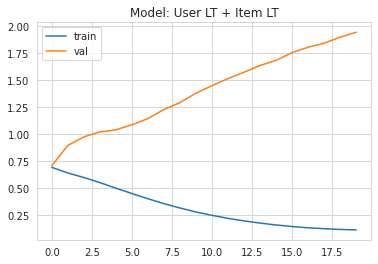

In [526]:
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val')
plt.legend()
plt.title("Model: User LT + Item LT")

from google.colab import files
plt.savefig("img1.png")
files.download("img1.png") 

## **BERT**: Get predictions

In [190]:
def get_feature_vector(model, inputs, batch_size):

  layer = model._modules.get('model1_layer3')

  embedding = torch.zeros((batch_size, 128))
  def copy_data(m, i, o):
          embedding.copy_(o.data)
  h = layer.register_forward_hook(copy_data)
  model(inputs)
  h.remove()
  return embedding

In [ ]:
predictions = {}
res = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])
dataloader_test=DataLoader(dataset=dataset_test,batch_size=128)

model.eval()


for data in dataloader_test:
      #items positions
      curr_items_ids_batch = data['track_id']
      # items descriptions
      curr_items_batch = data['input_ids'].to(device)
      curr_attentions_batch = data['attention_mask'].to(device)
      
      # users ids
      curr_users_batch =data['user_id'].to(device)

      # model inputs
      inputs = [curr_items_ids_batch.to(device).type(torch.LongTensor), curr_items_batch.type(torch.LongTensor), curr_users_batch.type(torch.LongTensor), curr_attentions_batch.type(torch.LongTensor)]


      with torch.no_grad():
        outputs = model(inputs)


      # save prediction for each user
      
      for i in range(outputs.shape[0]):

        res = res.append(pd.DataFrame({'user_id': id2user[curr_users_batch[i].item()], 'track_id': pos2item[curr_items_ids_batch[i].item()], 'count':  outputs[i].item()} , index=[0]))

        # real_user_id = id2user[curr_users_batch[i].item()]
        # try:
        #   predictions[real_user_id] 
        # except:
        #   predictions[real_user_id] = []

        # predictions[real_user_id].append([pos2item[curr_items_ids_batch[i].item()], 
        #                                   outputs[i].item()])
        
      # save embedding layer for each item
      # feature_vector = get_feature_vector(model, inputs, batch_size)
      # try:
      #   feature_vectors[pos2item[curr_items_ids_batch]]
      # except:
      #   feature_vectors[pos2item[curr_items_ids_batch]] = []
      # feature_vectors[pos2item[curr_items_ids_batch]].append(feature_vector)
        

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
res[res.user_id == 25679].sort_values('count', ascending = False).head(10)

In [ ]:
res[res.user_id == 119172].sort_values('count', ascending = False).head(10) 

In [ ]:
topn=10
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user, user_prediction in res.groupby('user_id'):
    results_df = results_df.append(user_prediction.sort_values('count', ascending=False).head(topn))
    

# Most popular recommendation


In [514]:
topn = 10

item_popularity_df = data_interaction_test.groupby(item_col)[rating_col].sum().sort_values(ascending=False).reset_index()

predictions = {}

for real_user_id in data_interaction_test.user_id.unique():
    predictions[real_user_id] = []
    items_to_ignore = data_interaction_train[data_interaction_train[user_col] == real_user_id]['track_id'].values
    item_popularity_df_user = item_popularity_df[~item_popularity_df[item_col].isin(items_to_ignore)]
    predictions[real_user_id].append(item_popularity_df_user.head(topn)[item_col].values.tolist())

In [515]:
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user in predictions:
    user_prediction = predictions[user][0]
    for item in user_prediction:
        rating = 1.
        results_df = pd.concat((results_df, pd.DataFrame(data={user_col:[user],item_col:[item],rating_col:[rating]})))
        results.append([user, item, rating])

# Random recommendation

In [511]:
topn = 10

predictions = {}

for real_user_id in data_interaction_test.user_id.unique():
    predictions[real_user_id] = []
    items_to_ignore = data_interaction_train[data_interaction_train[user_col] == real_user_id][item_col].values
    item_df_user = data_interaction_test[~data_interaction_test[item_col].isin(items_to_ignore)]
    predictions[real_user_id].append(random.sample(set(item_df_user['track_id'].values), topn))

In [512]:
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user in predictions:
    user_prediction = predictions[user][0]
    for item in user_prediction:
        rating = 1.
        results_df = pd.concat((results_df, pd.DataFrame(data={user_col:[user],item_col:[item],rating_col:[rating]})))
        results.append([user, item, rating])

# Evaluate predictions

Scores: F1@10, ndcg@k, recall@k

In [313]:
def get_ndcg(rel_pred, k):

  rel_true = np.zeros(len(df))
  rel_true[:k] = 1

  def _dcg(rel):
    i = np.arange(1, len(rel_pred)+ 1)
    denom = np.log2(i + 1)
    dcg = np.sum(rel / denom)
    return dcg

  return _dcg(rel_pred) / _dcg(rel_true)


In [ ]:
f1_scores = []
recall_scores = []
ndcg_scores = []

for user, df in results_df.groupby(user_col):
  df = df.drop_duplicates(subset=item_col)

  y_true_sorted = data_interaction_test.loc[data_interaction_test[user_col] == user].sort_values(rating_col, ascending=False).drop_duplicates()
  rel = pd.merge(df[[item_col]], y_true_sorted[[item_col, rating_col]].drop_duplicates(), 'left').fillna(0)['count'].values
  y_true_df = pd.merge(data_items_eval[[item_col]].drop_duplicates(), y_true_sorted[[item_col, rating_col]].drop_duplicates(), 'left').fillna(0)
  y_true_ndcg = y_true_df[rating_col].values
  y_true_df.loc[y_true_df[rating_col] > 0, rating_col] = 1
  y_true = y_true_df[rating_col].values

  y_pred_df = pd.merge(data_items_eval[[item_col]].drop_duplicates(), df[[item_col, rating_col]], 'left').fillna(0)
  y_pred_ndcg = y_pred_df[rating_col].values
  y_pred_df.loc[y_pred_df[rating_col] > 0, rating_col] = 1
  y_pred = y_pred_df[rating_col].values

  if y_true.sum() >= 2:
    f1_scores.append(f1_score(y_true, y_pred))
    recall_scores.append(recall_score(y_true, y_pred))
    ndcg_scores.append(get_ndcg(rel, topn))

print("F1 Score: ", np.mean(f1_scores))
print("Recall Score: ", np.mean(recall_scores))
print("NDCG Score: ", np.mean(ndcg_scores))

In [472]:
# lyrics: 0.009
# random: 0.003
# pop: 0.08

,user_id,track_id,count
0,119172,4634383,1.0
0,119172,6973199,1.0
0,119172,6415356,1.0
0,119172,4395379,1.0
0,119172,6358290,1.0
...,...,...,...
0,119172,4383937,1.0
0,119172,5171450,1.0
0,119172,4059867,1.0
0,119172,4772498,1.0


# Interpretability of Gender Bias

- Find correlations between user gender and item gender (Pearsons correlation)
- For each track get proportion of female/male user => compare train and recommendataion data
- Check if genderness increased/decreased in recommendations (in comparision to training data) 
- Compare distribution of genderness between history and recommendations 
  - "Delta Metric of Genderness" (https://arxiv.org/pdf/2108.06973.pdf)
  - Proportion tests: Fisher exact test, Chi-Square



## Data

In [316]:
data_items_eval

,track_artist,track_name,track_lyrics,lyrics_cleaned,language,track_id,track_tag,tags,abstract
0,charli xcx,!franchesckaar!,!Franchesckaar!\nThey all love you\n!Franchesc...,franchesckaar they all love you franchesckaar...,en,1968,"{'ridiculous and amazing': 100, 'electronic': ...",ridiculous and amazing electronic indie electr...,"charlotte emma aitchison , known professionall..."
2,maker,19 maple st.,"""19 Maple St.""\nWhats good with us these days?...",19 maple st. whats good with us these days do...,en,2269549,{'pop punk': 100},pop punk,band of merrymakers is a holiday music supergr...
4,sick of it all,2061,"""2061""\nWe'll be waiting sixty years for the t...",2061 we ll be waiting sixty years for the tru...,en,2469890,"{'Sick Of It All': 100, 'last act of defiance'...",Sick Of It All last act of defiance,sick of it all is an american hardcore punk ba...
20,sick of it all,b.s. justice,Another crime but it's not in the streets\nAno...,another crime but it s not in the streets anot...,en,5695170,"{'male vocalist': 100, 'hardcore punk': 100, '...",male vocalist hardcore punk english lyrics 198...,sick of it all is an american hardcore punk ba...
31,crippled black phoenix,444,"""444""\n\n(We got a loudspeaker here\nWhen we g...",444 we got a loudspeaker here when we go into...,en,2819742,"{'alternative rock': 100, 'post-rock': 100, 'i...",alternative rock post-rock indie rock Progress...,crippled black phoenix are an english rock ban...
...,...,...,...,...,...,...,...,...,...
29977,dezarie,all ova,Dezarie:\nStill rise fe do the work of Jah\nPe...,dezarie still rise fe do the work of jah perse...,en,4333763,"{'freedom': 100, 'rootsreggae': 100, 'Virgin I...",freedom rootsreggae Virgin Islands Reggae,dezarie is a female roots reggae singer born i...
29981,tropics,blame,Did I just let you go?\nFelt so wrong\nI must ...,did i just let you go felt so wrong i must hav...,en,7077315,"{'electronic': 100, 'chill': 100, 'british': 1...",electronic chill british indie electronic Ambi...,"in 1964 in tampa, florida, the band, the tropi..."
29996,leroy carr,alabama woman blues,Did you ever go down on the Mobile and K C lin...,did you ever go down on the mobile and k c lin...,en,4147411,"{'blues': 100, 'Classic Blues': 100}",blues Classic Blues,"leroy carr was an american blues singer, song..."
29997,magnum,all that is real,Did you ever give all of your heart and your s...,did you ever give all of your heart and your s...,en,4346729,"{'classic rock': 100, 'rock': 100, 'Superclean...",classic rock rock Superclean Dreammachine,"sami wolking , better known by his stage name ..."


In [317]:
data_interaction_new

,user_id,track_id,count,lyrics_cleaned,tags,abstract,fold
0,2827,4899211,0,anne you can t hide you know we ll find you it...,singer-songwriter rock John Frusciante experim...,john anthony frusciante is an american musici...,1
1,4441,4899211,1,anne you can t hide you know we ll find you it...,singer-songwriter rock John Frusciante experim...,john anthony frusciante is an american musici...,1
2,34084,4899211,1,anne you can t hide you know we ll find you it...,singer-songwriter rock John Frusciante experim...,john anthony frusciante is an american musici...,3
3,4931,4899211,1,anne you can t hide you know we ll find you it...,singer-songwriter rock John Frusciante experim...,john anthony frusciante is an american musici...,3
4,4631,4899211,0,anne you can t hide you know we ll find you it...,singer-songwriter rock John Frusciante experim...,john anthony frusciante is an american musici...,3
...,...,...,...,...,...,...,...
30303,57106,7000066,1,black is black i want my baby back and gray is...,rock pop rock cover Remakes 80s pop and rock,"richard lewis springthorpe , known professiona...",2
30304,3031,6025682,1,3 am and i know just where you re at locked up...,electronic electropop pop singer-songwriter am...,"kandice melonakos , better known by her stage ...",4
30305,2961,3164587,1,hey man i m glad you asked cause i know more ...,country texas country My Favorites gmix3 Love ...,deryl dwaine dodd is an american texas countr...,4
30306,4813,5017615,0,any day now i will hear you say goodbye my lov...,soul 70s sexy singer-songwriter favorites easy...,"eddie james kendrick , best known by the stage...",5


In [318]:
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_all_info = data_all_info[['track_artist', 'gender_artist', 'track_id']]


In [319]:
data_user = pd.read_csv("data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_user.columns = ['user_id', 'gender_user']

In [320]:
df_tmp = pd.merge(data_interaction_train, data_user, 'inner')
df_all = pd.merge(df_tmp, data_all_info, on = 'track_id').drop_duplicates()

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
df_all['gender_user'] = df_all['gender_user'].replace(replace_dict1)
df_all['gender_artist'] = df_all['gender_artist'].replace(replace_dict2)

df_train = df_all[df_all['count'] == 1]

In [321]:
df_tmp = pd.merge(data_interaction_test, data_user, 'inner')
df_all = pd.merge(df_tmp, data_all_info, on = 'track_id').drop_duplicates()

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
df_all['gender_user'] = df_all['gender_user'].replace(replace_dict1)
df_all['gender_artist'] = df_all['gender_artist'].replace(replace_dict2)

df_test = df_all[df_all['count'] == 1]

In [322]:
df_tmp = pd.merge(results_df, data_user, 'inner')
df_all = pd.merge(df_tmp, data_all_info, on = 'track_id').drop_duplicates()

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
df_all['gender_user'] = df_all['gender_user'].replace(replace_dict1)
df_all['gender_artist'] = df_all['gender_artist'].replace(replace_dict2)

df_rec = df_all

## Distribution of gender

In [323]:
print(f"In the history data, {round(df_train.gender_artist.sum() / len(df_train) * 100, 2)} % female items were consumed.")
print(f"In the test data, {round(df_test.gender_artist.sum() / len(df_test) * 100, 2)} % female items were consumed.")
print(f"In the recommendation data, {round(df_rec.gender_artist.sum() / len(df_rec) * 100, 2)} % female items were recommended.")

In the history data, 26.89 % female items were consumed.
In the test data, 12.5 % female items were consumed.
In the recommendation data, 28.0 % female items were recommended.


## Correlation between user and item gender

In [324]:
# Proportion of female items in all female user
prop_female = 0
# Proportion of female items in all male user
prop_male = 0
for group, df in df_train.groupby('gender_user'):
  if group == 0:
    prop_male = df.gender_artist.sum() / len(df)
  else:
    prop_female = df.gender_artist.sum() / len(df)

print(f'In the history data, all female users listen to {round(prop_female*100, 2)} % female items.')
print(f'In the history data, all male users listen to {round(prop_male*100, 2)} % female items.')

# Phi correlation (http://web.pdx.edu/~newsomj/pa551/lectur15.htm)
print('The attributes gender_user and gender_artist show a correlation of ', df_train.gender_user.corr(df_train.gender_artist))

In the history data, all female users listen to 39.46 % female items.
In the history data, all male users listen to 24.78 % female items.
The attributes gender_user and gender_artist show a correlation of  0.11629683976280156


In [325]:
# Proportion of female items in all female user
prop_female = 0
# Proportion of female items in all male user
prop_male = 0
for group, df in df_rec.groupby('gender_user'):
  if group == 0:
    prop_male = df.gender_artist.sum() / len(df)
  else:
    prop_female = df.gender_artist.sum() / len(df)

print(f'In the recommendation data, to all female users {round(prop_female*100, 2)} % female items are recommended.')
print(f'In the recommendation data, to all male users {round(prop_male*100, 2)} % female items are recommended.')

# Phi correlation
print('The attributes gender_user and gender_artist show a correlation of ', df_rec.gender_user.corr(df_rec.gender_artist))

In the recommendation data, to all female users 30.0 % female items are recommended.
In the recommendation data, to all male users 27.5 % female items are recommended.
The attributes gender_user and gender_artist show a correlation of  0.02227177015936874


## Delta metric of genderness

 For user u_i: (prop_female(rec) - prop_female(history)) / prop_female(history)

 If positive: more female tracks are recommended to the user

In [326]:
prop_female_rec = df_rec.gender_artist.sum() / len(df_rec)
prop_female_history = df_train.gender_artist.sum() / len(df_train)
delta = (prop_female_rec - prop_female_history) / prop_female_history

if delta > 0:
  print(f'The value of delta is {round(delta, 4)} and therefore more female tracks are recommended to user.')
else:
  print(f'The value of delta is {round(delta, 4)} and therefore more male tracks are recommended to user.')

The value of delta is 0.0412 and therefore more female tracks are recommended to user.


## Proportion distribution

In [327]:
prop_all = []
prop_male = []
prop_female = []
for user, df in df_train.groupby('user_id'):
  p = df.gender_artist.sum() / len(df)
  prop_all.append(p)
  if (df.gender_user).all() == 0:
    prop_male.append(p)
  else: prop_female.append(p)

print(f"In the history data, there were on average {round(np.mean(prop_all)*100, 2)} % female items consumed.")
print(f"In the history data, among all male users there were on average {round(np.mean(prop_male)*100, 2)} % female items consumed.")
print(f"In the history data, among all female users there were on average {round(np.mean(prop_female)*100, 2)} % female items consumed.")

In the history data, there were on average 26.8 % female items consumed.
In the history data, among all male users there were on average 24.4 % female items consumed.
In the history data, among all female users there were on average 40.41 % female items consumed.


In [328]:
prop_all = []
prop_male = []
prop_female = []
for user, df in df_rec.groupby('user_id'):
  p = df.gender_artist.sum() / len(df)
  prop_all.append(p)
  if (df.gender_user).all() == 0:
    prop_male.append(p)
  else: prop_female.append(p)

print(f"In the recommendation data, there are on average {round(np.mean(prop_all)*100, 2)} % female items recommended.")
print(f"In the recommendation data, among all male users there are on average {round(np.mean(prop_male)*100, 2)} % female items recommended.")
print(f"In the recommendation data, among all female users there are on average {round(np.mean(prop_female)*100, 2)} % female items recommended.")

In the recommendation data, there are on average 28.0 % female items recommended.
In the recommendation data, among all male users there are on average 27.5 % female items recommended.
In the recommendation data, among all female users there are on average 30.0 % female items recommended.


# BERT classification model

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import pickle
import pandas as pd


from smooth_gradient import SmoothGradient
from integrated_gradient import IntegratedGradient

import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import DistilBertConfig, DistilBertTokenizer
from transformers import BertTokenizer, BertModel, AdamW

from IPython.display import display, HTML

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ArtistDataset(Dataset):
    def __init__(self, data_all,tokenizer,max_length, text_col):
        super(ArtistDataset, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.text_col = text_col
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index][self.text_col]
        
        inputs = tokenizer.encode_plus(
            text1, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['gender_artist'], dtype=torch.float)
            }


In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes=2):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('prajjwal1/bert-tiny')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
import torch
from torch.nn.functional import softmax

import matplotlib
import matplotlib.pyplot as plt


class SaliencyInterpreter:
    def __init__(self,
                 model,
                 criterion,
                 tokenizer,
                 show_progress=True,
                 **kwargs):

        """
        :param model: nn.Module object - can be HuggingFace's model or custom one.
        :param criterion: torch criterion used to train your model.
        :param tokenizer: HuggingFace's tokenizer.
        :param show_progress: bool flag to show tqdm progress bar.
        :param kwargs:
            encoder: string indicates the HuggingFace's encoder, that has 'embeddings' attribute. Used
                if your model doesn't have 'get_input_embeddings' method to get access to encoder embeddings
        """

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.model.eval()
        self.criterion = criterion
        self.tokenizer = tokenizer
        self.show_progress = show_progress
        self.kwargs = kwargs
        # to save outputs in saliency_interpret
        self.batch_output = None

    def _get_gradients(self, batch):
        # set requires_grad to true for all parameters, but save original values to
        # restore them later
        original_param_name_to_requires_grad_dict = {}
        for param_name, param in self.model.named_parameters():
            original_param_name_to_requires_grad_dict[param_name] = param.requires_grad
            param.requires_grad = True
        embedding_gradients = []
        hooks = self._register_embedding_gradient_hooks(embedding_gradients)

        loss = self.forward_step(batch)

        self.model.zero_grad()
        loss.backward()

        for hook in hooks:
            hook.remove()

        # restore the original requires_grad values of the parameters
        for param_name, param in self.model.named_parameters():
            param.requires_grad = original_param_name_to_requires_grad_dict[param_name]

        return embedding_gradients[0]

    def _register_embedding_gradient_hooks(self, embedding_gradients):
        """
        Registers a backward hook on the
        Used to save the gradients of the embeddings for use in get_gradients()
        When there are multiple inputs (e.g., a passage and question), the hook
        will be called multiple times. We append all the embeddings gradients
        to a list.
        """

        def hook_layers(module, grad_in, grad_out):
            embedding_gradients.append(grad_out[0])

        backward_hooks = []
        embedding_layer = self.get_embeddings_layer()
        backward_hooks.append(embedding_layer.register_backward_hook(hook_layers))
        return backward_hooks

    def get_embeddings_layer(self):
        if hasattr(self.model, "get_input_embeddings"):
            embedding_layer = self.model.get_input_embeddings()
        else:
            encoder_attribute = self.kwargs.get("encoder")
            assert encoder_attribute, "Your model doesn't have 'get_input_embeddings' method, thus you " \
                "have provide 'encoder' key argument while initializing SaliencyInterpreter object"
            embedding_layer = getattr(self.model, encoder_attribute).embeddings
        return embedding_layer

    def colorize(self, instance, skip_special_tokens=False):

        special_tokens = self.special_tokens

        word_cmap = matplotlib.cm.Blues
        prob_cmap = matplotlib.cm.Greens
        template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
        colored_string = ''
        # Use a matplotlib normalizer in order to make clearer the difference between values
        normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=word_cmap).to_rgba(instance['grad'])
        for word, color in zip(instance['tokens'], normalized_and_mapped):
            if word in special_tokens and skip_special_tokens:
                continue
            # handle wordpieces
            word = word.replace("##", "") if "##" in word else ' ' + word
            color = matplotlib.colors.rgb2hex(color[:3])
            colored_string += template.format(color, word)
        colored_string += template.format(0, "    Label: {} |".format(instance['label']))
        prob = instance['prob']
        color = matplotlib.colors.rgb2hex(prob_cmap(prob)[:3])
        colored_string += template.format(color, "{:.2f}%".format(instance['prob']*100)) + '|'
        return colored_string

    @property
    def special_tokens(self):
        """
        Some tokenizers don't have 'eos_token' and 'bos_token' attributes.
        So needed we some trick to get them.
        """
        if self.tokenizer.bos_token is None or self.tokenizer.eos_token is None:
            special_tokens = self.tokenizer.build_inputs_with_special_tokens([])
            special_tokens_ids = self.tokenizer.convert_ids_to_tokens(special_tokens)
            self.tokenizer.bos_token, self.tokenizer.eos_token = special_tokens_ids

        special_tokens = self.tokenizer.eos_token, self.tokenizer.bos_token
        return special_tokens

    def forward_step(self, batch):
        """
        If your model receive inputs in another way or you computing not
         like in this example simply override this method. It should return the batch loss
        :param batch: batch returned by dataloader
        :return: torch.Tensor: batch loss
        """
        input_ids = batch.get('input_ids').to(self.device)
        attention_mask = batch.get("attention_mask").to(self.device)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        label = torch.argmax(outputs, dim=1)
        batch_losses = self.criterion(outputs, label)
        loss = torch.mean(batch_losses)

        self.batch_output = [input_ids, outputs]

        return loss

    def update_output(self):
        """
        You can also override this method if you want to change the format
         of outputs. (e.g. store just gradients)
        :return: batch_output
        """

        input_ids, outputs, grads = self.batch_output

        probs = softmax(outputs, dim=-1)
        probs, labels = torch.max(probs, dim=-1)

        tokens = [
            self.tokenizer.convert_ids_to_tokens(input_ids_)
            for input_ids_ in input_ids
        ]

        embedding_grads = grads.sum(dim=2)
        # norm for each sequence
        norms = torch.norm(embedding_grads, dim=1, p=1)
        # normalizing
        for i, norm in enumerate(norms):
            embedding_grads[i] = torch.abs(embedding_grads[i]) / norm

        batch_output = []

        iterator = zip(tokens, probs, embedding_grads, labels)

        for example_tokens, example_prob, example_grad, example_label in iterator:
            example_dict = dict()
            # as we do it by batches we has a padding so we need to remove it
            example_tokens = [t for t in example_tokens if t != self.tokenizer.pad_token]
            example_dict['tokens'] = example_tokens
            example_dict['grad'] = example_grad.cpu().tolist()[:len(example_tokens)]
            example_dict['label'] = example_label.item()
            example_dict['prob'] = example_prob.item()
            batch_output.append(example_dict)
        return batch_output

import torch

from tqdm import tqdm



class SmoothGradient(SaliencyInterpreter):
    """
    Interprets the prediction using SmoothGrad (https://arxiv.org/abs/1706.03825)
    Registered as a `SaliencyInterpreter` with name "smooth-gradient".
    """
    def __init__(self,
                 model,
                 criterion,
                 tokenizer,
                 stdev=0.01,
                 num_samples=20,
                 show_progress=True,
                 **kwargs):
        super().__init__(model, criterion, tokenizer, show_progress, **kwargs)
        # Hyperparameters
        self.stdev = stdev
        self.num_samples = num_samples

    def saliency_interpret(self, test_dataloader):

        instances_with_grads = []
        iterator = tqdm(test_dataloader) if self.show_progress else test_dataloader

        for batch in iterator:

            # we will store there batch outputs such as gradients, probability, tokens
            # so as each of them are used in different places, for convenience we will create
            # it as attribute:
            self.batch_output = []
            self._smooth_grads(batch)
            batch_output = self.update_output()
            instances_with_grads.extend(batch_output)

        return instances_with_grads

    def _register_forward_hook(self, stdev: float):
        """
        Register a forward hook on the embedding layer which adds random noise to every embedding.
        Used for one term in the SmoothGrad sum.
        """

        def forward_hook(module, inputs, output):
            # Random noise = N(0, stdev * (max-min))
            scale = output.detach().max() - output.detach().min()
            noise = torch.randn(output.shape).to(output.device) * stdev * scale

            # Add the random noise
            output.add_(noise)

        # Register the hook
        embedding_layer = self.get_embeddings_layer()
        handle = embedding_layer.register_forward_hook(forward_hook)
        return handle

    def _smooth_grads(self, batch):
        total_gradients = None
        for _ in range(self.num_samples):
            handle = self._register_forward_hook(self.stdev)
            grads = self._get_gradients(batch)
            handle.remove()

            # Sum gradients
            if total_gradients is None:
                total_gradients = grads
            else:
                total_gradients = total_gradients + grads

        total_gradients /= self.num_samples

        self.batch_output.append(total_gradients)

In [ ]:
data_all_info = data_all_info.drop_duplicates()

class_0 = data_all_info[data_all_info['gender_artist'] == 0]
class_1 = data_all_info[data_all_info['gender_artist'] == 1]
class_count_0, class_count_1 = data_all_info['gender_artist'].value_counts()

class_0_under = class_0.sample(class_count_1)
test_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 

dataset_train= ArtistDataset(test_under,tokenizer, 128, 'lyrics_cleaned')

dataloader_train=DataLoader(dataset=dataset_train,batch_size=32)

In [ ]:
import gc

gc.collect()

395

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# model = BertForSequenceClassification.from_pretrained(
#     'bert-base-uncased', 
#     num_labels = 2, 
#     output_attentions = False, 
#     output_hidden_states = False, 
# ).to(device)
model = SentimentClassifier().to(device)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 3
loss_fn = nn.CrossEntropyLoss().to(device)
total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

for epoch_i in range(0, epochs):
    
    losses = []
    model.train()

    for step, batch in enumerate(dataloader_train):

        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['target'].type(torch.LongTensor).to(device)
    

        outputs = model(
          input_ids=b_input_ids,
          attention_mask=b_input_mask
        )
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, b_labels)

        losses.append(loss.item())

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()

        optimizer.zero_grad()
    print(f"Epoch {epoch_i}, Loss {np.mean(losses)}")


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 0, Loss 0.8120180043202322
Epoch 1, Loss 1.2906241224402875
Epoch 2, Loss 0.8140014462766394


In [ ]:
integrated_grad = SmoothGradient(
    model, 
    loss_fn, 
    tokenizer, 
    show_progress=False,
    encoder="bert"
)
instances = integrated_grad.saliency_interpret(dataloader_train)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
words_male = []
words_female = []
for i in range(len(instances)):
  idx = np.argsort(instances[i]['grad'])[::-1][:10]
  if instances[i]['label'] == 0:
    words_male = words_male + [instances[i]['tokens'][val] for val in idx]
  else: 
    words_female = words_female + [instances[i]['tokens'][val] for val in idx]

words_male = [ elem for elem in words_male if elem not in ['[SEP]', '[CLS]']]
words_female = [ elem for elem in words_female if elem not in ['[SEP]', '[CLS]']]

In [ ]:
len(words_female)

24197

In [ ]:
coloder_string = integrated_grad.colorize(instances[0])
display(HTML(coloder_string))

Using bos_token, but it is not set yet.


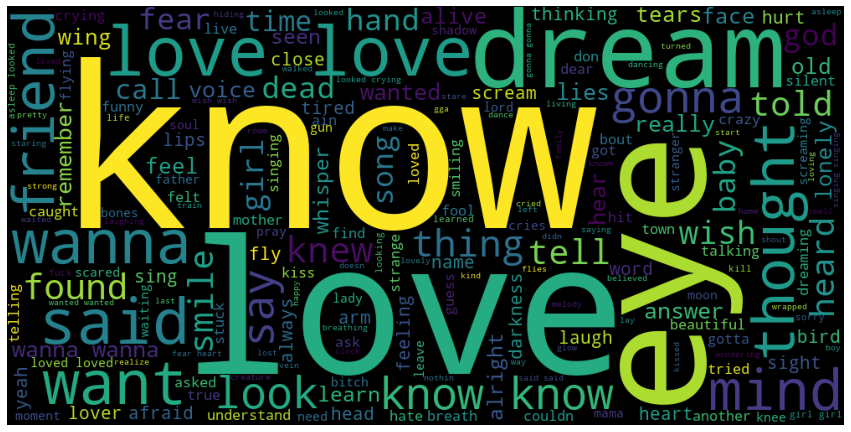

dict_keys(['know', 'love', 'eye', 'dream', 'love love', 'said', 'want', 'wanna', 'thought', 'friend', 'mind', 'gonna', 'know know', 'look', 'say', 'thing', 'knew', 'found', 'tell', 'smile', 'told', 'heard', 'wish', 'girl', 'god', 'baby', 'dead', 'fear', 'hand', 'song', 'time', 'call', 'wanna wanna', 'voice', 'hear', 'wanted', 'really', 'remember', 'answer', 'lies', 'tears', 'face', 'feel', 'lonely', 'old', 'alive', 'wing', 'learn', 'whisper', 'seen', 'alright', 'thinking', 'name', 'hurt', 'sight', 'sing', 'fly', 'lover', 'laugh', 'close', 'head', 'heart', 'yeah', 'scream', 'tired', 'feeling', 'arm', 'always', 'afraid', 'lips', 'bird', 'darkness', 'word', 'talking', 'singing', 'crying', 'mother', 'understand', 'ask', 'dreaming', 'silent', 'telling', 'felt', 'gotta', 'beautiful', 'fool', 'couldn', 'tried', 'loved', 'dear', 'strange', 'guess', 'bout', 'got', 'live', 'hate', 'kiss', 'asked', 'smiling', 'caught', 'another', 'hit', 'town', 'find', 'breath', 'true', 'ain', 'stuck', 'flying', 

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join(words_female)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print(wordcloud.words_.keys())

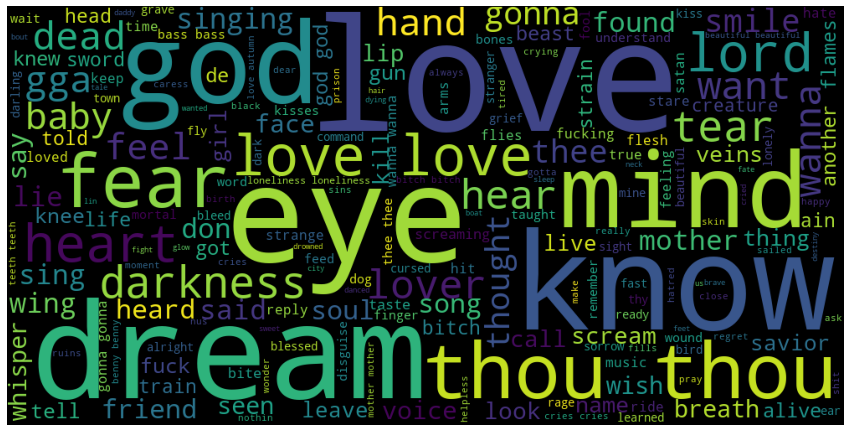

dict_keys(['love', 'eye', 'know', 'dream', 'god', 'mind', 'thou thou', 'fear', 'love love', 'lord', 'heart', 'darkness', 'tear', 'hear', 'lover', 'want', 'dead', 'gga', 'wanna', 'hand', 'baby', 'feel', 'gonna', 'thought', 'smile', 'thee', 'singing', 'mother', 'said', 'found', 'don', 'sing', 'wing', 'lie', 'say', 'soul', 'friend', 'heard', 'song', 'voice', 'face', 'seen', 'wish', 'breath', 'whisper', 'scream', 'call', 'look', 'lip', 'veins', 'name', 'thing', 'girl', 'leave', 'kill', 'live', 'savior', 'fuck', 'gun', 'tell', 'knee', 'life', 'knew', 'alive', 'beast', 'got', 'another', 'de', 'god god', 'flames', 'bitch', 'told', 'ain', 'head', 'sword', 'train', 'strain', 'creature', 'screaming', 'taste', 'bite', 'flesh', 'time', 'fucking', 'satan', 'arms', 'true', 'hit', 'hate', 'strange', 'flies', 'music', 'stare', 'feeling', 'keep', 'ride', 'loved', 'reply', 'gonna gonna', 'wanna wanna', 'mortal', 'disguise', 'wait', 'kisses', 'feed', 'fool', 'taught', 'dog', 'bones', 'word', 'understand'

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join(words_male)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print(wordcloud.words_.keys())

# Predict artist gender

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [ ]:
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_all_info = data_all_info.loc[data_all_info.artist_gender != 'other' ]

In [ ]:
input = feature_vectors

In [ ]:
df_features = pd.DataFrame()
id_col = []

for id in data_interaction_test[item_col].unique():
  id_col.append(id)
  df_features = df_features.append(pd.DataFrame(input[id][0].detach().numpy()))

df_features[item_col] = id_col

In [ ]:
df_features = pd.merge(df_features, data_all_info)

In [ ]:
df_features.loc[df_features.artist_gender == 'female', 'artist_gender'] = 0
df_features.loc[df_features.artist_gender == 'male', 'artist_gender'] = 1
df_features.artist_gender = df_features.artist_gender.astype('int')

In [ ]:
X = df_features.iloc[:,:128]
y = df_features.artist_gender
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

In [ ]:
#clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test.values, y_pred))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test.values, y_pred))
print("Recall: ", metrics.recall_score(y_test.values, y_pred))
print("Precision: ", metrics.precision_score(y_test.values, y_pred))

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp.head(10)